In [1]:
import torch
import pytorch_lightning as pl
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from pytorch_lightning.loggers import CSVLogger
from torch.optim import Adam
from torch.nn.functional import cross_entropy
from torchmetrics.functional import accuracy
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [2]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.RandomVerticalFlip(p = 0.1),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [3]:
class BreaKHisDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, transform, batch_size):
        super().__init__()
        self.data_dir = data_dir
        self.transform = transform
        self.batch_size = batch_size

    def setup(self, stage= None):
        breakhis_full = ImageFolder(self.data_dir, transform = data_transforms)
        train_size = round(len(breakhis_full) * 0.56)
        val_size = round(len(breakhis_full) * 0.14)
        test_size = round(len(breakhis_full) * 0.3)
        self.train_dataset, self.val_dataset, self.test_dataset = random_split(breakhis_full, [train_size, val_size, test_size])
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False)
    
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)
    
    def show_images_with_labels(self, dataloader):
        # Get a batch of data from the dataloader
        images, labels = next(iter(dataloader))

        # Unnormalize the images
        inv_transform = transforms.Compose([
            transforms.Normalize(mean=[0, 0, 0], std=[1 / 0.229, 1 / 0.224, 1 / 0.225]),
            transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
        ])
        unnorm_images = torch.stack([inv_transform(img) for img in images])

        # Get class labels
        classes = dataloader.dataset.classes

        # Display the images with their labels
        fig, axs = plt.subplots(2, 5, figsize=(15, 6))
        for i in range(2):
            for j in range(5):
                idx = i * 5 + j
                ax = axs[i, j]
                ax.imshow(unnorm_images[idx].permute(1, 2, 0))
                ax.set_title(f"Class: {classes[labels[idx]]}")
                ax.axis('off')
        plt.show()



In [4]:
data_dir = './BreaKHis/'
breakhis_dm = BreaKHisDataModule(data_dir=data_dir, batch_size=64, transform=data_transforms)
breakhis_dm.setup()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


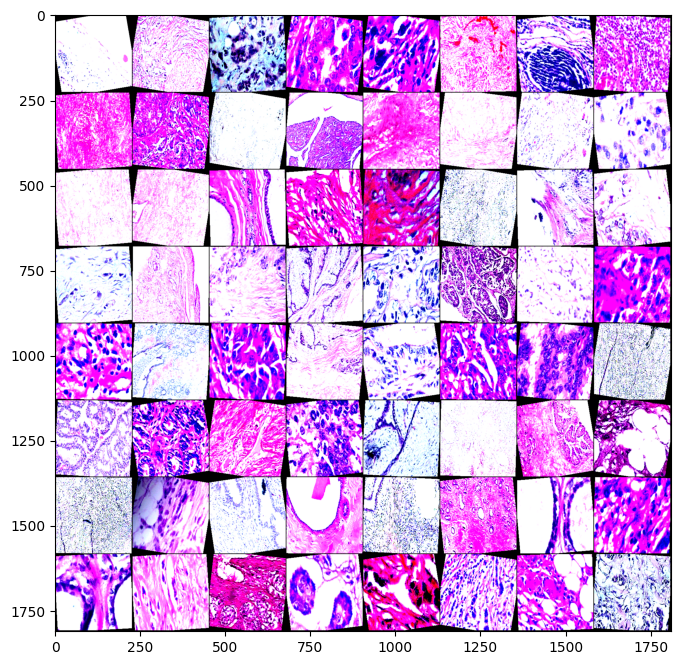

In [5]:
def display_images(dataloader):
    for images, labels in dataloader:
        figure, axis = plt.subplots(figsize = (14, 8))
        axis.imshow(make_grid(images, nrow = 8).permute(1, 2, 0))
        break

display_images(breakhis_dm.train_dataloader())

In [14]:
class DINOV2Classifier(pl.LightningModule):
    def __init__(self, num_classes, lr = 1e-3):
        super().__init__()
        self.save_hyperparameters()
        dinov2 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')
        self.backbone = dinov2
        self.head = torch.nn.Sequential(
            torch.nn.Linear(768, 2048),
            torch.nn.ReLU(),
            torch.nn.Linear(2048, num_classes)
        )

    def forward(self, x):
        with torch.no_grad():
            features = self.backbone(x)
        logits = self.head(features)
        return logits
            
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = cross_entropy(logits, y)
        accuracy_score = accuracy(logits, y)
        metrics = {'train_loss': loss, 'train_acc': accuracy_score}
        self.log_dict(metrics, on_step = False, on_epoch = True, 
                      prog_bar = True, logger = True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch   
        features = self.backbone(x)
        logits = self.head(features)
        loss = cross_entropy(logits, y)
        accuracy_score = accuracy(logits, y)
        metrics = {'valid_loss': loss, 'valid_acc': accuracy_score}
        self.log_dict(metrics, on_step = False, on_epoch = True, 
                      prog_bar = True, logger = True)
        
        return metrics
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = cross_entropy(logits, y)
        accuracy_score = accuracy(logits, y)

        return {'test_loss': loss, 'test_acc': accuracy_score}
    
    def test_epoch_end(self, outputs):
        # Calculate average test loss and accuracy across all batches
        avg_test_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        avg_test_acc = torch.stack([x['test_acc'] for x in outputs]).mean()

        # Log the test results
        self.log('test_loss', avg_test_loss, prog_bar=True)
        self.log('test_acc', avg_test_acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr = self.hparams.lr)
        return optimizer

In [15]:
num_classes = 8
dinov2_logger = CSVLogger(save_dir = './breakhis_log', name = 'dinov2_v4')

In [16]:
dinov2_classifier = DINOV2Classifier(num_classes=num_classes)
dinov2_trainer = pl.Trainer(max_epochs = 40,
                     limit_train_batches = 64, 
                     log_every_n_steps = 10, logger = dinov2_logger, accelerator='cpu')
dinov2_trainer.fit(dinov2_classifier, breakhis_dm)
torch.save(dinov2_classifier.state_dict(), "./dinov2_breakhis_v4.pt")

Using cache found in /Users/kennyyeung/.cache/torch/hub/facebookresearch_dinov2_main
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/kennyyeung/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
Missing logger folder: ./breakhis_log/dinov2_v4

  | Name     | Type                  | Params
---------------------------------------------------
0 | backbone | DinoVisionTransformer | 86.6 M
1 | head     | Sequential            | 1.6 M 
---------------------------------------------------
88.2 M    Trainable params
0         Non-trainable params
88.2 M    Total params
352.687   Total estimated model params size (MB)


/Users/kennyyeung/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 39: 100%|██████████| 82/82 [10:13<00:00,  7.48s/it, loss=0.192, v_num=0, valid_loss=0.579, valid_acc=0.812, train_loss=0.180, train_acc=0.934]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 82/82 [10:13<00:00,  7.48s/it, loss=0.192, v_num=0, valid_loss=0.579, valid_acc=0.812, train_loss=0.180, train_acc=0.934]


In [17]:
dinov2_state_dict = torch.load('./dinov2_breakhis_v4.pt')
dinov2_model = DINOV2Classifier(num_classes=8)
dinov2_model.load_state_dict(dinov2_state_dict)
dinov2_trainer.test(dinov2_model, breakhis_dm.test_dataloader())

Using cache found in /Users/kennyyeung/.cache/torch/hub/facebookresearch_dinov2_main
/Users/kennyyeung/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 38/38 [04:46<00:00,  7.55s/it]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8180098533630371     │
│         test_loss         │    0.5613536238670349     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5613536238670349, 'test_acc': 0.8180098533630371}]

In [2]:
def create_graph(logger_path, name):
    training_metrics = pd.read_csv(f'{logger_path}/metrics.csv')
    train_loss = training_metrics['train_loss'].dropna().reset_index(drop = True)
    train_acc = training_metrics['train_acc'].dropna().reset_index(drop = True)
    valid_loss = training_metrics['valid_loss'].dropna().reset_index(drop = True)
    valid_acc = training_metrics['valid_acc'].dropna().reset_index(drop = True)  
    figure = plt.figure(figsize = (12, 6))
    plt.title(f'{name} Accuracies', fontsize=28)
    plt.xlabel('Epoch', fontsize = 24)
    plt.ylabel('Accuracy', fontsize = 24)
    plt.plot(train_acc, color = 'g', marker = 'x', label = 'Training Accuracy')
    plt.plot(valid_acc, color = 'm', marker = 'o', label = 'Validation Accuracy')
    plt.legend(loc = 'lower right', fontsize = 18)
    plt.grid(True)
    plt.savefig(f'{logger_path}/accuracy_{name}.png')
    train_loss = training_metrics['train_loss'].dropna().reset_index(drop = True)
    valid_loss = training_metrics['valid_loss'].dropna().reset_index(drop = True)
    fig = plt.figure(figsize = (12, 6))
    title = "{title_name} Loss".format(title_name = name)
    plt.title(title, fontsize=28)
    plt.xlabel('Epoch', fontsize = 24)
    plt.ylabel('Loss', fontsize = 24)
    plt.plot(train_loss, color = 'g', marker = 'x', label = 'Training Loss')
    plt.plot(valid_loss, color = 'm', marker = 'o', label = 'Validation Loss')
    plt.legend(loc = 'upper right', fontsize = 18)
    plt.grid(True)
    plt.savefig(f'{logger_path}/loss_{name}.png')

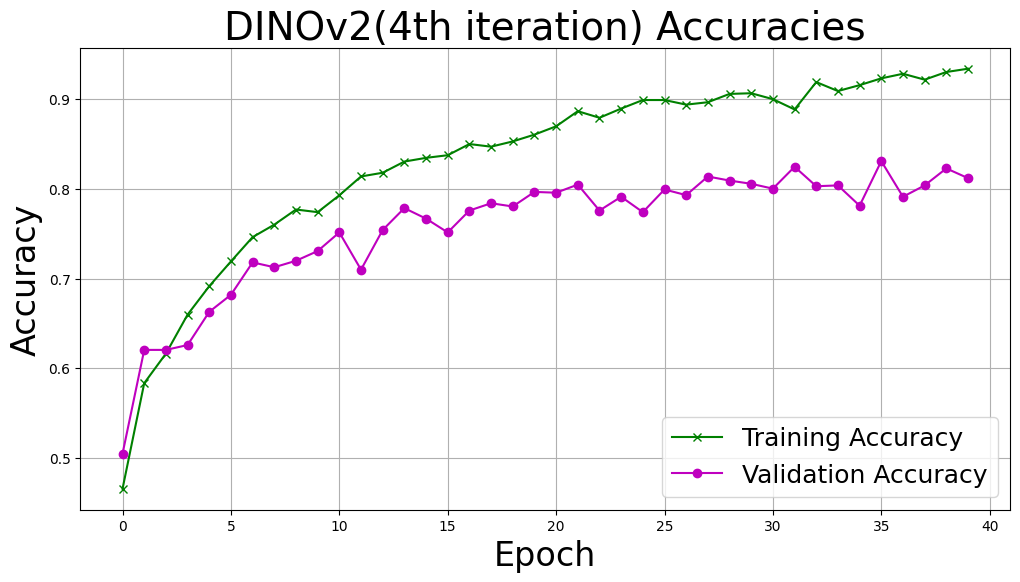

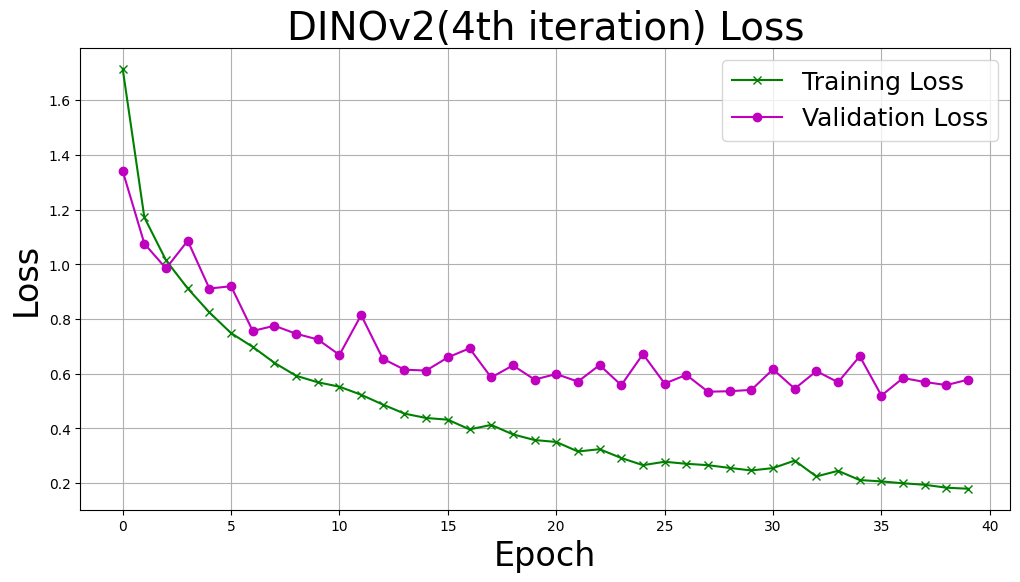

In [3]:
path = './breakhis_log/dinov2_v4/version_0'
create_graph(path, "DINOv2(4th iteration)")